In [269]:
import sys
import os
os.chdir("C:\\Users\\Zber\\Documents\\Dev_program\\OpenRadar")
import numpy as np
import mmwave.dsp as dsp
import mmwave.dsp.music as music
import mmwave.clustering as clu
from mmwave.dataloader import DCA1000
from demo.visualizer.visualize import ellipse_visualize
from FER.data_processing.mediapipe_facemesh_one import flm_detector, distance
from scipy import signal

from mmwave.dsp.utils import Window
from mmwave.dsp import utils
import math
from FER.utils import parseConfigFile, arange_tx

from itertools import accumulate
from operator import add
from mmwave.dsp.cfar import ca

from scipy.signal import find_peaks, peak_widths
# import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')

from mpl_toolkits.mplot3d import Axes3D


from matplotlib import cm

plt.close('all')

DebugMode = True

if not DebugMode:
    import matplotlib

    matplotlib.use('Agg')

# plotting color
import matplotlib._color_data as mcd

tab_color = [mcd.TABLEAU_COLORS[name] for name in mcd.TABLEAU_COLORS]
extra_color = ['#acc2d9', '#56ae57', '#b2996e', '#a8ff04']
tab_color = tab_color + extra_color

# figpath = "C:/Users/Zber/Desktop/mmWave_figure"
figpath = "C:/Users/Zber/Desktop/SavedFigure"
configFileName = 'C:/Users/Zber/Desktop/mmWave Configuration/profile_3d_aop_3s.cfg'

In [270]:
# num Antennas
numTxAntennas = 3
numRxAntennas = 4
# load configure parameters
config = parseConfigFile(configFileName)

# mmWave radar settings
numFrames = config['numFrames']
numADCSamples = config['numAdcSamples']
numLoopsPerFrame = config['numLoops']
numChirpsPerFrame = numTxAntennas * numLoopsPerFrame
numAngleBins = 64

# aoa related
VIRT_ELE_PAIRS = [[8, 2], [9, 3], [10, 4], [11, 5]]
VIRT_AZI_PAIRS = [[i for i in range(0, 8)]]

# azimuth
ANGLE_RES_AZI = 1
ANGLE_RANGE_AZI = 60
ANGLE_BINS_AZI = (ANGLE_RANGE_AZI * 2) // ANGLE_RES_AZI + 1
VIRT_ANT_AZI = 8

# elevation
ANGLE_RES_ELE = 1
ANGLE_RANGE_ELE = 30
ANGLE_BINS_ELE = (ANGLE_RANGE_ELE * 2) // ANGLE_RES_ELE + 1
VIRT_ANT_ELE = 2

BIN_RANG_S = 0
BIN_RANG_E = 256
BINS_PROCESSED = BIN_RANG_E - BIN_RANG_S
VIRT_ANT_AZI_INDEX = [i for i in range(0, 8)]
VIRT_ANT_ELE_INDEX = VIRT_ELE_PAIRS[2]

# data processing parameter
range_resolution, bandwidth = dsp.range_resolution(config['numAdcSamples'],
                                                    dig_out_sample_rate=config['digOutSampleRate'],
                                                    freq_slope_const=config['freqSlopeConst'])

doppler_resolution = dsp.doppler_resolution(bandwidth, start_freq_const=config['startFreq'],
                                            ramp_end_time=config['rampEndTime'],
                                            idle_time_const=config['idleTime'],
                                            num_loops_per_frame=config['numLoops'],
                                            num_tx_antennas=numTxAntennas)

print('Range Resolution: {:.2f}cm, Bandwidth: {:.2f}Ghz, Doppler Resolution: {:.2f}m/s'.format(
    range_resolution * 100, bandwidth / 1000000000, doppler_resolution))
unit = 0.042158314406249994

Range Resolution: 4.22cm, Bandwidth: 3.56Ghz, Doppler Resolution: 0.43m/s


In [271]:
# adc_data_path = "D:/Subjects/Distance_100cm/Anger__Raw_0.bin"
# adc_data_path = "D:/Subjects/Distance_100cm/Joy_0_Raw_0.bin"
adc_data_path = "D:/Subjects/M2_1/Joy_0_Raw_0.bin"

In [272]:
# Reading in adc data
adc_data = np.fromfile(adc_data_path, dtype=np.int16)
adc_data = adc_data.reshape(numFrames, -1)
adc_data = np.apply_along_axis(DCA1000.organize_cli, 1, adc_data, num_chirps=numChirpsPerFrame,
                                num_rx=numRxAntennas, num_samples=numADCSamples)
print("Data Loaded!")

# processing range data
# window types : Bartlett, Blackman p, Hanning p and Hamming
# range_data = dsp.range_processing(adc_data, window_type_1d=Window.HANNING)
range_data = dsp.range_processing(adc_data)
range_data = arange_tx(range_data, num_tx=numTxAntennas)

Data Loaded!


(300, 32, 12, 256)


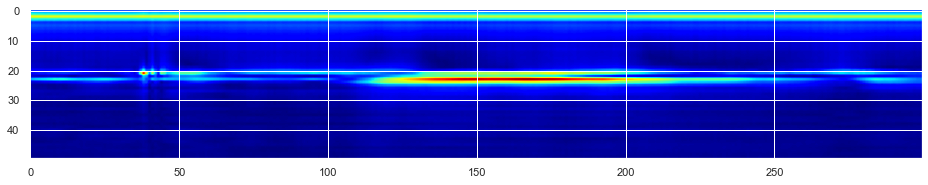

In [273]:
# range profile
print(range_data.shape)
fig5, axes5 = plt.subplots(1, 1, figsize=(16, 9))
range_plot_data = np.mean(range_data[:,15,:,:50],axis=(1))
# range_plot_data = np.mean(range_data,axis=(1,2))
# range_plot_data = range_data[:,15,2,:50]
axes5.imshow(np.abs(range_plot_data.T), cmap=plt.get_cmap('jet'))

# range doppler processing


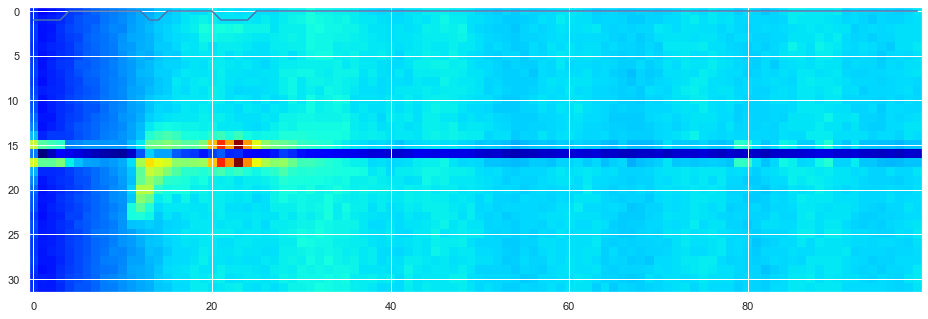

In [274]:
# %matplotlib widget
s_bin = 0
e_bin = s_bin + 100
# %matplotlib inline
fig, axes = plt.subplots(1, 1, figsize=(16, 9))
det_matrix, aoa_input = dsp.doppler_processing_frame(range_data, num_tx_antennas=numTxAntennas,
                                                    clutter_removal_enabled=True,
                                                    window_type_2d=Window.HAMMING,
                                                    accumulate=True)

# det_matrix, aoa_input = doppler_processing(range_data, num_tx_antennas=numTxAntennas,
#                                                     clutter_removal_enabled=True,
#                                                     window_type_2d=Window.HAMMING,
#                                                     accumulate=True)

det_matrix_vis = np.fft.fftshift(det_matrix, axes=2)
det_matrix_vis_mean = np.mean(det_matrix_vis[:, :, :], axis=0)
# det_matrix_vis_mean = np.mean(det_matrix_vis[50:100, :, :], axis=0)
bin_data = det_matrix_vis_mean[:, 17] + det_matrix_vis_mean[:, 15]

peak_data = ca(bin_data, guard_len=2, noise_len=4, l_bound=8)[s_bin:e_bin]

axes.plot(peak_data)
# axes.axvline(x=20, color='r', linestyle='-')
# axes.axvline(x=24, color='r', linestyle='-')

axes.imshow(np.abs(det_matrix_vis_mean.T[:,s_bin:e_bin]), cmap=plt.get_cmap('jet'))



In [275]:
det_matrix_vis.shape
offset = 5
peak_data = peak_data[offset:offset+200]
detect_pos = np.where(peak_data == True)[0]
detect_pos += offset
print(detect_pos)

[13 14 21 22 23 24]


In [276]:
# bin_start = detect_pos[0]
# bin_end = detect_pos[-4]

# bin_start = detect_pos[0]
# bin_end = detect_pos[-1]


# 28 -> 31 facial expression clear
# 29 -> 32 not clear
# bin_start = 28
# bin_end = 31

bin_start = 21
bin_end = 26


print("start {}, end {}".format(bin_start, bin_end))
num_vec_azi, steering_vec_azi = dsp.gen_steering_vec(ANGLE_RANGE_AZI, ANGLE_RES_AZI, VIRT_ANT_AZI)
num_vec_ele, steering_vec_ele = dsp.gen_steering_vec(ANGLE_RANGE_ELE, ANGLE_RES_ELE, VIRT_ANT_ELE)

start 21, end 26


In [277]:
print(aoa_input.shape)
aoa_input = np.transpose(aoa_input, (0,3,2,1))
print(aoa_input.shape)

(300, 256, 12, 32)
(300, 32, 12, 256)


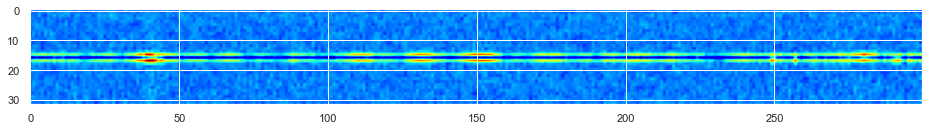

In [278]:
#micro doppler plot
d_start = bin_start
d_end = bin_end + 1

fig3, axes3 = plt.subplots(1, 1, figsize=(16, 9))
det_matrix_vis_mean = np.mean(det_matrix_vis[:, d_start:d_end, :], axis=1)
axes3.imshow(np.abs(det_matrix_vis_mean.T), cmap=plt.cm.jet)


In [279]:
# capon processing
num_bins = bin_end-bin_start
npy_azi = np.zeros((numFrames, ANGLE_BINS_AZI, num_bins))
npy_ele = np.zeros((numFrames, ANGLE_BINS_ELE, num_bins))
for i in range(0, 300):
    rb = 0
    for r in range(bin_start, bin_end):
        chirp_data_azi= aoa_input[i, :, VIRT_ANT_AZI_INDEX, r]
        # capon beamformer
        capon_angle_azi, beamWeights_azi = dsp.aoa_capon(chirp_data_azi, steering_vec_azi, magnitude=True)
        npy_azi[i, : , rb] = capon_angle_azi

        chirp_data_ele= aoa_input[i, :, VIRT_ANT_ELE_INDEX, r]
        # capon beamformer
        capon_angle_ele, beamWeights_ele = dsp.aoa_capon(chirp_data_ele, steering_vec_ele, magnitude=True)
        npy_ele[i, : , rb] = capon_angle_ele

        rb += 1

In [289]:
# capon processing
ar_sb = 0
ar_eb = 100

# ar_sb = 20
# ar_eb = 30

num_bins = ar_eb - ar_sb
ar_npy_azi = np.zeros((numFrames, ANGLE_BINS_AZI, num_bins))
ar_npy_ele = np.zeros((numFrames, ANGLE_BINS_ELE, num_bins))
for i in range(0, 300):
    rb = 0
    for r in range(ar_sb, ar_eb):
        chirp_data_azi= range_data[i, :, VIRT_ANT_AZI_INDEX, r]
        # capon beamformer
        # capon_angle_azi, beamWeights_azi = dsp.aoa_capon(chirp_data_azi, steering_vec_azi, magnitude=True)
        capon_angle_azi = music.aoa_music_1D(steering_vec_azi, chirp_data_azi, 1)
        ar_npy_azi[i, : , rb] = capon_angle_azi

        chirp_data_ele= range_data[i, :, VIRT_ANT_ELE_INDEX, r]
        # capon beamformer
        # capon_angle_ele, beamWeights_ele = dsp.aoa_capon(chirp_data_ele, steering_vec_ele, magnitude=True)
        capon_angle_ele = music.aoa_music_1D(steering_vec_ele, chirp_data_ele, 1)

        ar_npy_ele[i, : , rb] = capon_angle_ele
        rb += 1

In [281]:
# import matplotlib.pyplot as plt
# import matplotlib.colors as colors
# import numpy as np

# def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
#     new_cmap = colors.LinearSegmentedColormap.from_list(
#         'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
#         cmap(np.linspace(minval, maxval, n)))
#     return new_cmap

# cmap = plt.get_cmap('hot')
# new_cmap = truncate_colormap(cmap, 0.0, 0.5)


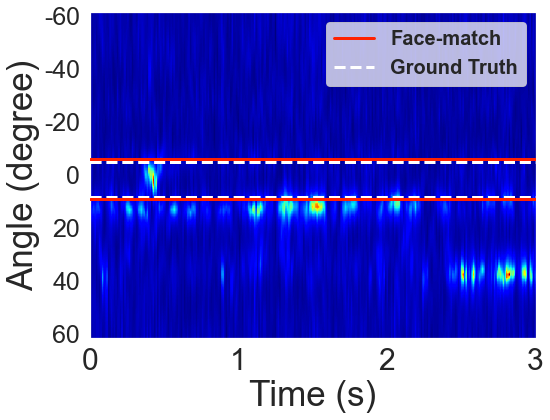

In [319]:
plt.rcParams["axes.grid"] = False
fig1, axes1 = plt.subplots(1, 1, figsize=(8, 6))

txt = np.arange(-60, 61, step=20)
pos = np.linspace(1,119,7)
axes1.set_yticks(pos)
axes1.set_yticklabels(txt,fontsize=25)
xpos_label = np.arange(0,4, step=1)
xpos = xpos_label * 99.5
axes1.axhline(54, c='#ff2100', label='Face-match',  lw=3, zorder=5)
axes1.axhline(69, c='#ff2100', lw=3, zorder=5)



axes1.axhline(55, c='white', lw=3,label='Ground Truth',  linestyle='dashed')
axes1.axhline(68, c='white', lw=3, linestyle='dashed')

axes1.set_xticks(xpos)
axes1.set_xticklabels(xpos_label,fontsize=30)
axes1.set_ylabel("Angle (degree)",fontsize=35)
axes1.set_xlabel("Time (s)",fontsize=35)
axes1.imshow(np.mean(npy_azi, 2).T, cmap=plt.cm.jet, aspect='auto')
# axes1.legend(loc="upper left", prop={'size': 30, }, ncol=1, bbox_to_anchor=(0.0, 0.2), fancybox=True,
#       framealpha=0.0, labelspacing=0.05, handletextpad=0.2, columnspacing=0.5, handlelength=1.5)
axes1.legend( prop={'size': 20, 'weight':'bold'})
fig1.savefig('C:/Users/Zber/Desktop/mmEmo_Exp/0.Method/m1_5_aoa_time.svg', format='svg', bbox_inches="tight")
# fig1.savefig('C:/Users/Zber/Desktop/mmEmo_Exp/0.Method/m1_5_aoa_time.svg', format='svg', bbox_inches="tight")


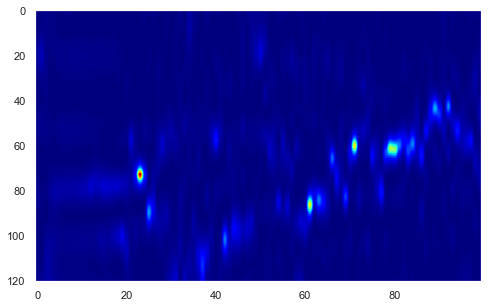

In [290]:
fig2, axes2 = plt.subplots(1, 1, figsize=(8, 5))
# ss, ee = 50, 70

# sub 1
ss, ee = 50, 90
# ar_npy_ele = 20 * np.log10(ar_npy_ele + 1)

# axes2.imshow(ar_npy_azi[f_num], cmap=plt.cm.jet, aspect='auto')
# axes2.imshow(np.mean(ar_npy_azi[ss:ee], axis=0)-np.mean(ar_npy_azi[0:f_num], axis=0), cmap=plt.cm.jet, aspect='auto')

# axes2.imshow(np.mean(ar_npy_azi[ss:ee], axis=0)-np.mean(ar_npy_azi[0:f_num], axis=0), cmap=plt.cm.hot, aspect='auto')


axes2.imshow(ar_npy_azi[ss], cmap=plt.cm.jet, aspect='auto')

# axes2[1].imshow(ar_npy_ele[f_num], cmap=plt.cm.jet, aspect='auto')

# axes2[0].imshow(np.mean(ar_npy_azi[30:70], axis=0), cmap=plt.cm.jet, aspect='auto')
# axes2[1].imshow(np.mean(ar_npy_ele[30:70], axis=0), cmap=plt.cm.jet, aspect='auto')

In [70]:
X = np.arange(-60,61, step = 1)
Y = np.arange(0, (30-0.01)* unit, step= unit)
X, Y = np.meshgrid(X, Y)
Z = ar_npy_azi[ee].T    

c:\Users\Zber\anaconda3\envs\Emo\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


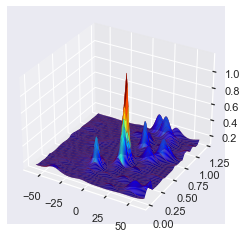

In [71]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet,
                       edgecolor='darkred', linewidth=0.1)

plt.show()


In [62]:
Z.shape

(121, 30)

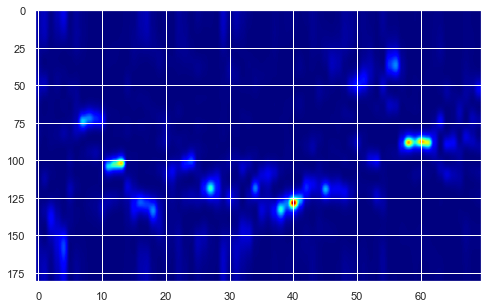

In [123]:
fig3, axes3 = plt.subplots(1, 1, figsize=(8, 5))
f_num = 30
# ar_npy_azi = 20 * np.log10(ar_npy_azi + 1)
# ar_npy_ele = 20 * np.log10(ar_npy_ele + 1)

axes3.imshow(np.mean(ar_npy_azi[0:f_num], axis=0), cmap=plt.cm.jet, aspect='auto')

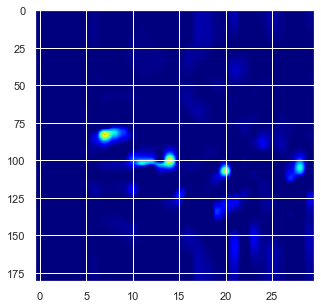

In [173]:
fig4, axes4 = plt.subplots(1, 1, figsize=(5, 5))
# ss, ee = 50, 70

# sub 1
ss, ee = 70, 90
fs = 30
axes4.imshow(ar_npy_azi[ee] - ar_npy_azi[fs], cmap=plt.cm.jet, vmin=0.0, vmax=0.5, aspect='auto')
# axes4.imshow(ar_npy_azi[ee] - ar_npy_azi[fs], cmap=plt.cm.jet,aspect='auto')

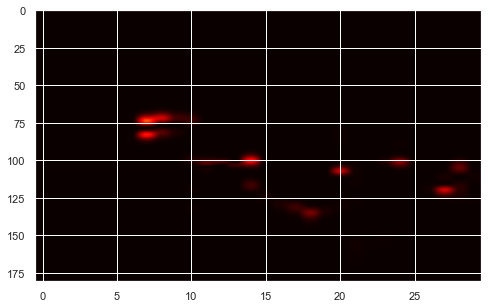

In [193]:
fig5, axes5 = plt.subplots(1, 1, figsize=(8, 5))
data = (ar_npy_azi[ee] - ar_npy_azi[fs])**2
# plot_data = (data - np.mean(data))/np.max(data)

# axes5.imshow(norm_data**2, cmap=plt.cm.jet,aspect='auto')
axes5.imshow(data, cmap=new_cmap, aspect='auto')
# axes5.imshow(data, cmap=plt.cm.jet,aspect='auto')

In [182]:
np.min(plot_data)

0.0

In [107]:
np.max(ar_npy_azi)

2.448529516681344

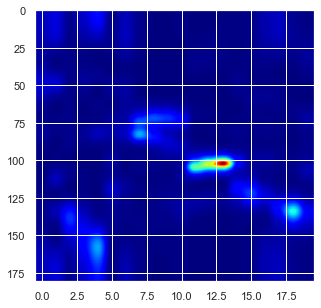

In [25]:
fig5, axes5 = plt.subplots(1, 1, figsize=(5, 5))
# ss, ee = 50, 70

# sub 1
ss, ee = 70, 90
fs = 30
axes5.imshow(np.mean(ar_npy_azi[30:130], axis=0), cmap=plt.cm.jet, aspect='auto')

In [65]:
aoa_input = np.fft.fftshift(aoa_input, axes=1)
num_angle_bins = 120

range_angle = np.zeros((300, num_angle_bins, 256))

for i in range(len(aoa_input)):
    range_doppler = aoa_input[i]
    padding = ((0,0), (0,num_angle_bins-range_doppler.shape[1]), (0,0))
    range_azimuth = np.pad(range_doppler, padding, mode='constant')
    range_azimuth = np.fft.fft(range_azimuth, axis=1)
    range_azimuth = np.log(np.abs(range_azimuth).sum(0))
    range_angle[i] = range_azimuth

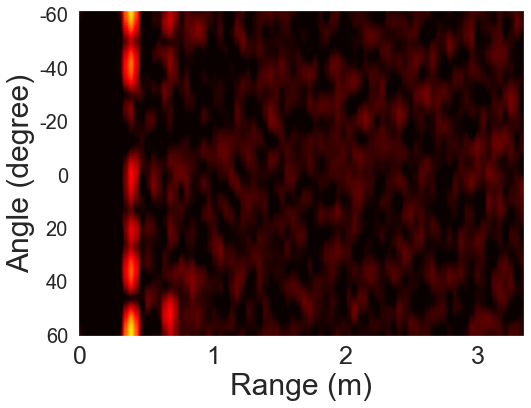

In [261]:
plt.rcParams["axes.grid"] = False
fig7, axes7 = plt.subplots(1, 1, figsize=(8, 6))
f_num = 30



range_angle_s = np.square(range_angle[:,:,:80])
plot_data = (range_angle_s[ss] - np.min(range_angle_s[ss]))/np.max(range_angle_s[ss])
# axes6.imshow(np.mean(range_angle[0:f_num,:,:20], axis=0), cmap=plt.cm.jet, aspect='auto')
# axes7.imshow(range_angle_s[ee], cmap=plt.cm.hot, vmin=0.0, vmax=0.8, aspect='auto')
pos = np.linspace(1,119,7)
# pos_1 = (1+ 119)/2
# pos = pos + [pos_1]
# txt_1 = 0
txt = np.arange(-60, 61, step=20)
# txt = txt + txt_1
axes7.set_yticks(pos)
axes7.set_yticklabels(txt,fontsize=20)
max_range = range_angle_s.shape[2]
xpos_label = np.arange(0,4, step=1)
xpos = xpos_label/unit
axes7.set_xticks(xpos)
axes7.set_xticklabels(xpos_label,fontsize=25)

axes7.set_ylabel("Angle (degree)",fontsize=30)

axes7.set_xlabel("Range (m)",fontsize=30)
axes7.imshow(plot_data, cmap=plt.cm.hot, vmin=0.1, vmax=0.5, aspect='auto')

fig7.savefig('C:/Users/Zber/Desktop/mmEmo_Exp/0.Method/angleFFT_heatmap.svg',format='svg', bbox_inches="tight")



# axes6.imshow(range_angle_s[ee]-range_angle_s[ss], cmap=plt.cm.jet, aspect='auto')